In [1]:
# 파이썬 언어로 머신러닝 패키지:
# 사이킷럿 && STATSMODEL(시계열)

In [1]:
# 프로젝트 기간이 짧거나/ 업체가 공격적으로 투자하지 않을때 머신러닝 사용!!

In [2]:
# 특성(Features): 알고싶은 답에 영향을 주는 변수
# 답(Label): 특성에 따라 반응하는 변수

# 1. 라이브러리 정의

In [32]:
# 데이터 처리 라이브러리
import pandas as pd
import numpy as np

# 분석 알고리즘 DecisionTree 구현 라이브러리
from sklearn.tree import DecisionTreeRegressor # 설명력

# from sklearn.ensemble import RandomForestRegressor # 정확도

# from sklearn.linear_model import LogisticRegression # yes or no 문제 

# from sklearn.linear_model import LinearRegression # 가장 많이 사용함 

from sklearn.preprocessing import LabelEncoder # 라벨을 숫자로 변경

# 과거데이터를 8:2, 7:3 이나 이런식으로 자동으로 나누어주는 함수
from sklearn.model_selection import train_test_split

#분석 regression # 평가 대표 지표 (MAE, RMSE)
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 

from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import LinearRegression

In [2]:
### 2. 데이터 불러오기

In [3]:
# feature 는 숫자여야만 한다

featuresData = \
    pd.read_csv("../dataset/feature_regression_example.csv")
featuresData.head(2)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442


In [4]:
## 1. 데이터 전처리

In [5]:
### 1-1. 타입 통합 / 특성 숫자컬럼 추가

In [6]:
### 1-1-1. 데이터 타입 통합

In [7]:
#featuresData.info()

# 주의할 사항은 모든 컬럼에 대해서 고정시키는걸 고려하는게 나을수도 있다
featuresData.QTY = featuresData.QTY.astype(float)

In [8]:
### 1-1-2. 특성 값 숫자 컬럼 변경

# 이유: 머신러닝 특성은 숫자형 지원
# - 해결: Y ->1, N -> 0 과 같이 변환

featuresData["HOLIDAY_NEW"] = \
    np.where(featuresData.HOLIDAY=="Y",1,0)

In [9]:
# 라벨 숫자로 변경
holiEn = LabelEncoder()

In [10]:
featuresData["HOLIDAY_LABEL_EN"] = holiEn.fit_transform(featuresData.HOLIDAY)
holiEn.inverse_transform(featuresData.HOLIDAY_LABEL_EN)

#pd.DataFrame( featuresData.HOLIDAY.drop_duplicates()).reset_index().\
#   rename(columns={}"index":"HOLIDAY_NEW"})

featuresData["PROMOTION_NEW"] = \
    np.where(featuresData.PROMOTION=="Y",1,0)

featuresData.dtypes

REGIONID             object
PRODUCTGROUP         object
PRODUCT              object
ITEM                 object
YEARWEEK              int64
YEAR                  int64
WEEK                  int64
QTY                 float64
HOLIDAY              object
HCLUS                 int64
PROMOTION            object
PRO_PERCENT         float64
HOLIDAY_NEW           int32
HOLIDAY_LABEL_EN      int32
PROMOTION_NEW         int32
dtype: object

In [11]:
### 1-2.특성 선정 / 데이터 분리

In [12]:
### 1-2-1. 특성 선정

In [37]:
corrDf = featuresData.corr() # 상관개수 # 프로젝트에서 가장 먼저 시작

standardLimit = 0.5

features = \
    list(corrDf.loc[(abs(corrDf.QTY) > standardLimit) & 
                    (corrDf.QTY != 1)].index)

features

['HCLUS', 'PRO_PERCENT', 'HOLIDAY_NEW', 'HOLIDAY_LABEL_EN', 'PROMOTION_NEW']

In [38]:
label = ["QTY"] # db에서 가져온 값 (하드코딩 X)

### 1-2-2. 데이터 분리

# 과거 실적데이터~!! 7/3, 8/2 분리

standardIndex = 0.8

featuresData.shape

sortKey = ["REGIONID","ITEM","YEARWEEK"]

sortedData = featuresData.sort_values(sortKey, ignore_index=True)

selectedIndex = int( list( sortedData.shape)[0] * standardIndex)
# 정렬하고 80%에 있는 인덱스의 번호로 분리시킨다~

yearweekStd = sortedData.loc[selectedIndex].YEARWEEK

yearweekStd

201632

In [13]:
# 훈련데이터와 테스트데이터를 (문제지와 정답지로 구분해서 정의한다.)
trainingDataFeatures = \
    sortedData.loc[sortedData.YEARWEEK <= yearweekStd, features]
trainingDataLabel = \
    sortedData.loc[sortedData.YEARWEEK <= yearweekStd, label]
testDataFeatures = \
    sortedData.loc[sortedData.YEARWEEK > yearweekStd, features]
testDataLabel = \
    sortedData.loc[sortedData.YEARWEEK > yearweekStd, label]

In [39]:
trainingDataLabel

,QTY
0,1225.0
1,968.0
2,1209.0
3,1810.0
4,1773.0
...,...
80,1616.0
81,1318.0
82,2240.0
83,1522.0


In [40]:
trainingDataFeatures

,HCLUS,PRO_PERCENT,HOLIDAY_NEW,HOLIDAY_LABEL_EN,PROMOTION_NEW
0,1,0.209442,1,1,1
1,4,0.209442,0,0,1
2,4,0.208155,0,0,1
3,2,0.208155,1,1,1
4,4,0.208155,0,0,1
...,...,...,...,...,...
80,1,0.308584,1,1,1
81,1,0.308584,1,1,1
82,4,0.280258,0,0,1
83,4,0.280258,0,0,1


## 2. 모델적용

### 2-1. 모델 적용

In [14]:
### 2-1-1 학습

In [15]:
# 하이퍼 파라미터 튜닝!!!
model = DecisionTreeRegressor(random_state=10)

model.fit(X=trainingDataFeatures, y=trainingDataLabel)

DecisionTreeRegressor(random_state=10)

In [16]:
# radomforest 방식!
rfmodel = RandomForestRegressor(random_state=10)

rfmodel.fit(X=trainingDataFeatures, y=trainingDataLabel)

<ipython-input-16-549c6e626ea5>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfmodel.fit(X=trainingDataFeatures, y=trainingDataLabel)


RandomForestRegressor(random_state=10)

In [34]:
# linearRegression
model_lr = LinearRegression()
model_lr.fit(X=trainingDataFeatures, y=trainingDataLabel)

LinearRegression()

## 3. 예측

In [17]:
predictValue = model.predict(testDataFeatures)

predictDf = \
    pd.DataFrame( list(predictValue ), columns=["PREDICT"])

# graphviz 로 뜯어볼수 있다
# explainable ai

In [18]:
# radomforest
rfpredictValue = rfmodel.predict(testDataFeatures)

In [19]:
rfpredictDf = \
    pd.DataFrame( list(rfpredictValue ), columns=["PREDICT"])

In [35]:
predictValueLr = model_lr.predict(testDataFeatures)

In [36]:
testDataAll["PREDICT_DT"] = predictValueDt
testDataAll["PREDICT_FR"] = predictValueRf

testDataAll["PREDICT_LR"] = predictValueLr

NameError: name 'predictValueDt' is not defined

## 4. 데이터 정리

In [21]:
rfvalidateDf = \
    pd.concat([testDataLabel.reset_index(drop=True), rfpredictDf], axis=1)

## 5. 정확도 검증

In [31]:
features

['HCLUS', 'PRO_PERCENT', 'HOLIDAY_NEW', 'HOLIDAY_LABEL_EN', 'PROMOTION_NEW']

In [22]:
mae = mean_absolute_error(y_true=validateDf.QTY,
                   y_pred=validateDf.PREDICT)

rmse = np.sqrt(mean_absolute_error(y_true=validateDf.QTY,
                   y_pred=validateDf.PREDICT))

In [23]:
# 장점:
# DecisionTree => 과거의 경험치를 그래도 반영한다
#                 변동성이 큰 데이터에서 강하다
#                 설명력이 강하다
# 단점:
#  오버피팅 - 과거에 집착 미래 예측 불가 
#  randomforest ->
#    장점: DecisionTree 오버피팅을 해결
#    단점: 설명력이 어려움

## 6. 결과 검증

In [24]:
mae

462.0403571428572

In [25]:
rmse

21.4951240318091

In [26]:
mae1 = mean_absolute_error(y_true=rfvalidateDf.QTY,
                   y_pred=rfvalidateDf.PREDICT)

rmse1 = np.sqrt(mean_absolute_error(y_true=rfvalidateDf.QTY,
                   y_pred=rfvalidateDf.PREDICT))

In [27]:
mae1

399.2856794302984

In [28]:
rmse1

19.982134005913842

## 7. 결과 시각화 및 분석

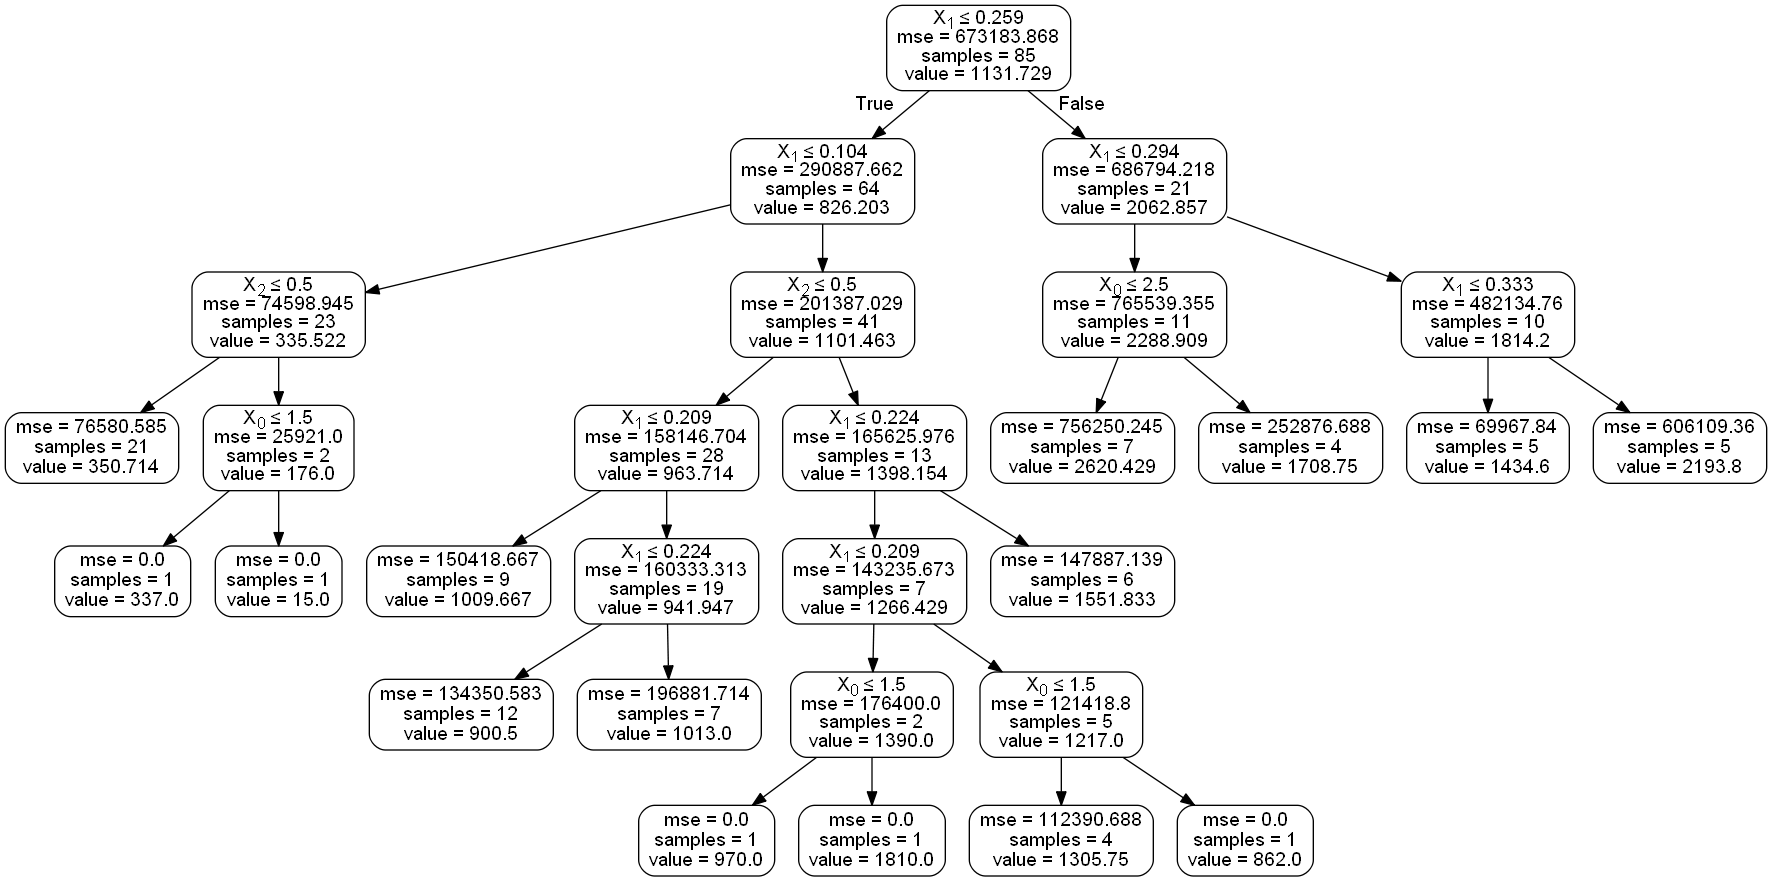

In [29]:
from six import StringIO 
from IPython.display import Image 
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, 
rounded=True,
special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

In [30]:
# 데이터 처리 라이브러리
import pandas as pd
import numpy as np
# 분석알고리즘 DecisionTree 구현 라이브러리
from sklearn.tree import DecisionTreeRegressor 
# 과거데이터를 8:2, 7:3 이나 이런식으로 자동으로 나누어주는 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sys
import pickle

In [30]:
loadedModel= "finalized_model.sav"
loaded_model2 = pickle.load(open(loadedModel, 'rb'))
loaded_model2

userInputHCLUS = 1
userInputProPercent=0.5
userInputHoilidayYn = 1
userInputPromotionYn = 1

futureData = pd.DataFrame([[ userInputHCLUS,
              userInputProPercent,
              userInputHoilidayYn,
              userInputPromotionYn]]   )

# pickle 파일로 저장가능하다.

print(loaded_model2.predict(futureData))

FileNotFoundError: [Errno 2] No such file or directory: 'finalized_model.sav'